In [1]:
from PIL import Image
import os
import glob
import random
import csv
random.seed(4)
import json
import pandas as pd
import numpy as np
import tqdm
# Non propre A DELETE
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
# ENDELETE
import torch
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as transforms

from torchvision.utils import draw_bounding_boxes
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
import albumentations as A
## A nettoyer
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [2]:
### DEFINITION DES FONCTIONS ###
class ObjectDetectionDataset(Dataset):
    """
    Custom PyTorch Dataset Class to facilitate loading data for the Object Detection Task
    """
    def __init__(self, 
                 annotations,  
                 mapping = None, 
                 mode = 'train', 
                 transform = None,path_to_images = './data2/train/'): 
        """ 
        Args:
            annotations: The path to the annotations CSV file. Format: file_name, classes, xmin, ymin, xmax, ymax
            train_test_valid_split: The path to the tags CSV file for train, test, valid split. Format: file_name, tag
            mapping: a dictionary containing mapping of class name and class index. Format : {'class_name' : 'class_index'}, Default: None
            mode: Mode in which to instantiate class. Default: 'train'
            transform: The transforms to be applied to the image data

        Returns:
            image : Torch Tensor, target: Torch Tensor, file_name : str
        """
        self.mapping = mapping
        self.transform = transform
        self.mode = mode

        self.path_to_images = path_to_images
        # Loading the annotation file (same format as Remo's)
        
        #my_data = pd.read_csv(annotations)
        
        # Here we append the file path to the filename. 
        # If dataset.export_annotations_to_file was used to create the annotation file, it would feature by default image file paths
        
        #my_data['file_name'] = my_data['file_name'].apply(lambda x : os.path.abspath(f'{self.path_to_images}{x}'))
        #my_data = my_data.set_index('file_name')
        data = read_file(annotations)
        my_data  = extractDataSetFromCOCO(data,path_to_images)
        my_data['file_name'] = path_to_images +  my_data['file_name']
        # Loading the train/test split file (same format as Remo's)
        #my_data['tag'] = pd.read_csv(train_test_valid_split, index_col='file_name')
        
        #my_data = my_data.reset_index()
        # Load only Train/Test/Split depending on the mode
        #my_data = my_data.loc[my_data['tag'] == mode].reset_index(drop=True)
        self.data = my_data

        self.file_names = self.data['file_name'].unique()

    def __len__(self) -> int:
        return self.file_names.shape[0]

    def __getitem__(self, index: int):

        file_name = self.file_names[index]
        records = self.data[self.data['file_name'] == file_name].reset_index()       
        image = np.array(Image.open(file_name), dtype=np.float32)
        image /= 255.0

        if self.transform:
            image = self.transform(image)  

        # here we are assuming we don't have labels for the test set
        if self.mode != 'test':
            boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)

            if self.mapping is not None:
                labels = np.zeros((records.shape[0],))

                for i in range(records.shape[0]):
                    labels[i] = self.mapping[records.loc[i, 'classes']]

                labels = torch.as_tensor(labels, dtype=torch.int64)

            else:
                labels = torch.ones((records.shape[0],), dtype=torch.int64)

            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['image_id'] = torch.tensor([index])
            target['area'] = area
            target['iscrowd'] = iscrowd 
            target['boxes'] = torch.stack(list((map(torch.tensor, target['boxes'])))).type(torch.float32)

            return image, target, file_name
        else:
            return image, file_name

def collate_fn(batch):
    return tuple(zip(*batch))

def read_file(path_to_file):
    # Read annotations
    with open(path_to_file, 'r') as f:
        dataset = json.loads(f.read())
    return dataset

def extractDataSetFromCOCO(dataset,imagePath):
    df = pd.DataFrame()
    categories = [row['name'] for row in dataset['categories']]
    images = [row['file_name'] for row in dataset['images']]
    df['classes'] = [row['category_id'] for row in dataset['annotations']]
    df['file_name'] = [row['image_id'] for row in dataset['annotations']]
    df['file_name'] = [images[i] for i in df['file_name']]
    df['classes'] = [categories[i] for i in df['classes']]
    ## A DELETE ALED
    df['image'] = [ img_to_array(load_img(imagePath + '/' + fil)) for fil in df['file_name']] #Très sale, à voir pour faire mieux
    #, target_size=(224, 224)
    
    df['xmin'] = [row['bbox'][0] for row in dataset['annotations']]
    df['ymin'] = [row['bbox'][1] for row in dataset['annotations']]
    df['xmax'] = [row['bbox'][0]+row['bbox'][2] for row in dataset['annotations']]
    df['ymax'] = [row['bbox'][1]+row['bbox'][3] for row in dataset['annotations']]
    return df

def evaluate(data_loader,device): 
    detection_threshold = 0.3
    results = []
    model.eval()
    data_loader = tqdm.tqdm(data_loader)

    with torch.no_grad():
        for images, image_ids in data_loader:

            images = list(image.to(device) for image in images)
            outputs = model(images)

            for i, image in enumerate(images):

                boxes = outputs[i]['boxes'].data.cpu().numpy()
                scores = outputs[i]['scores'].data.cpu().numpy()
                boxes = boxes[scores >= detection_threshold].astype(np.int32)
                scores = scores[scores >= detection_threshold]
                image_id = image_ids[i]

                for box, labels in zip(boxes, outputs[i]['labels']):
                    results.append({'file_name' : os.path.basename(image_id), 
                                    'classes'   : mapping[labels.item()], 
                                    'xmin'      : box[0],
                                    'ymin'      : box[1],
                                    'xmax'      : box[2],
                                    'ymax'      : box[3]})
    return results

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def show_img(image_path,file_name): # A EDITER
    img = read_image(image_path + file_name)
    l_boxes = []
    for row in results:
        if row['file_name'] == file_name:
            l_boxes.append([row['xmin'],row['ymin'],row['xmax'],row['ymax']])

    boxes = torch.tensor(l_boxes, dtype=torch.float)
    colors = ["blue"]
    result = draw_bounding_boxes(img, boxes, width=5)
    show(result)

In [3]:
### CONFIG ###
cat_to_index = {'other': 1, 
                'pet': 2,
                'eps-polystyrene-': 3, 
                'plastic_bag' : 4 
                }
device      = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 5
loss_value  = 0.0
num_epochs  = 4

In [4]:
### LOAD DATASET ###

path_to_annotations = './data3/train/'
annotations_file_path = os.path.join(path_to_annotations, 'annotations.json')

tensor_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = ObjectDetectionDataset(annotations = annotations_file_path,  
                                       transform = tensor_transform,
                                       mapping = cat_to_index,
                                       mode = 'train',path_to_images = './data3/train/')

train_data_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [5]:
### TELECHARGEMENT DU MODELE ###
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005) # IMPROVE WITH ADAM !
#optimizer = torch.optim.Adam(params, lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [6]:
### ENTRAINEMENT DU MODELE ###
for epoch in range(num_epochs):

    train_data_loader = tqdm.tqdm(train_data_loader)
    for images, targets, image_ids in train_data_loader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
    print('\nTraining Loss : {:.5f}'.format(loss_value))
torch.save(model,"model3SGD")
print("Fin de l'entrainement, modele sauvegardé")


  0%|                                                                                           | 0/79 [00:00<?, ?it/s]c:\users\maxim\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|                                                                                           | 0/79 [00:00<?, ?it/s]


Training Loss : 0.14140


  0%|                                                                                           | 0/79 [00:00<?, ?it/s]


Training Loss : 0.16576


  0%|                                                                                           | 0/79 [00:00<?, ?it/s]


Training Loss : 0.11983


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [13:04<00:00,  9.94s/it]



Training Loss : 0.09956
Fin de l'entrainement, modele sauvegardé


In [7]:
#### ZONE DE GUERRE #1 ####

transform = A.Compose([
    #A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='albumentations', min_area=12, min_visibility=0.1)) #, label_fields=['class_labels']


In [8]:
dataset = read_file('data3/train/annotations.json')
df = extractDataSetFromCOCO(dataset,'data3/train/')

In [9]:
nbe = 303
img = df['image'][nbe]/255
(x,y,z) = img.shape
df['xmin'] = df['xmin']/x
df['xmax'] = df['xmax']/x
df['ymin'] = df['ymin']/y
df['ymax'] = df['ymax']/y
box = list(df[['xmin','ymin','xmax','ymax','classes']].iloc[nbe,:])
transformed = transform(image=img, bboxes=[box],class_labels=list(df['classes'].unique())) # , class_categories=class_categories

In [10]:
transformed['image']  *= 255
transformed['image'] = transformed['image'].astype(int)


In [11]:
image = torch.from_numpy(transformed['image']).to(torch.uint8)
box = np.array(transformed['bboxes'][0][0:-1])
box[0] *= x
box[2] *= x
box[1] *= y
box[3] *= y
print(box)
print(image.shape)


[2463. 1509. 2988. 1944.]
torch.Size([3024, 4032, 3])


tensor([[0.0341, 0.0655, 0.0463, 0.0724]])


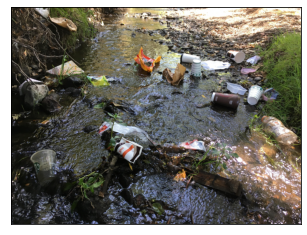

In [12]:

plt.rcParams["savefig.bbox"] = 'tight'
colors = ["blue"]
nbe = 280
image = torch.from_numpy(df['image'][nbe]/255).to(torch.uint8)
box = list(df[['xmin','ymin','xmax','ymax']].iloc[nbe,:])
image = torch.from_numpy(transformed['image']).to(torch.uint8)
image = torch.swapdims(image,0,1)
image = torch.swapdims(image,0,2)
bboxes = torch.tensor([box],dtype=torch.float)
print(bboxes)
result = draw_bounding_boxes(image,bboxes,width=4)
show(result)

In [13]:
print(x,y)
print((box[0], box[3]), box[3]-box[1], box[2]-box[0],)

3024 4032
(0.03406084656084656, 0.07242063492063493) 0.0069444444444444475 0.012235449735449731


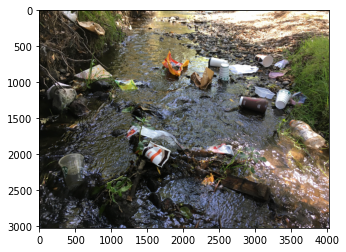

In [14]:
image = torch.from_numpy(transformed['image']).to(torch.uint8)
image = torch.swapdims(image,0,1)
image = torch.swapdims(image,0,2)
fig, ax = plt.subplots()

# Display the image
ax.imshow(image.permute(1, 2, 0))

# Create a Rectangle patch
#rect = patches.Rectangle((box[0], box[1]), box[3]-box[1], box[2]-box[0], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
#ax.add_patch(rect)
plt.show()

In [15]:
from bbaug import policies

image = df['image'][12]/255
bounding_boxes =  list(df[['xmin','ymin','xmax','ymax']].iloc[12,:])
labels =[ cat_to_index[classe] for classe in df['classes']]

# select policy v0 set
aug_policy = policies.policies_v0()
 
# instantiate the policy container with the selected policy set
policy_container = policies.PolicyContainer(aug_policy)

# select a random policy from the policy set
random_policy = policy_container.select_random_policy() 

# Apply the augmentation. Returns the augmented image and bounding boxes.
# Image is a numpy array of the image
# Bounding boxes is a list of list of bounding boxes in pixels (int).
# e.g. [[x_min, y_min, x_man, y_max], [x_min, y_min, x_man, y_max]]
# Labels are the class labels for the bounding boxes as an iterable of ints e.g. [1,0]
img_aug, bbs_aug = policy_container.apply_augmentation(random_policy, image, [bounding_boxes], labels)
# image_aug: numpy array of the augmented image

xmin    0.135251
ymin    0.035962
xmax    0.147817
ymax    0.043155
Name: 235, dtype: float64


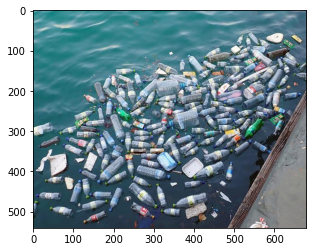

In [16]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=1)
#box = bbs_aug[0,1:]
nbe = 235
image = df['image'][nbe]/255
bounding_boxes =  list(df[['xmin','ymin','xmax','ymax']].iloc[nbe,:])
box = df[['xmin','ymin','xmax','ymax']].iloc[nbe,:]
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)
print(box)
# Create a Rectangle patch
#rect = patches.Rectangle((box[0], box[1]), box[3]-box[1], box[2]-box[0], linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(create_corner_rect(box))
# Add the patch to the Axes
#ax.add_patch(rect)
plt.show()

In [17]:
import torchvision
a = torchvision.utils.draw_bounding_boxes(
    image,
    list(df[['xmin','ymin','xmax','ymax']].iloc[12,:]),
)

TypeError: Tensor expected, got <class 'numpy.ndarray'>